# Exploraty Spatial Data Analysis

Spatial Autocorrelation article and examples <br>
https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee


Example notebooks: <br>
https://pysal.org/esda/notebooks/spatialautocorrelation.html <br>
https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn

import pysal
from pysal.lib  import weights
from pysal.explore import  esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# Load in shapefile with infections
gdf = gpd.read_file('../Shape/AI_Covid_NUTS-Regions.shp')

In [3]:
# Filter out relevant attributes (columns)

gdf = gdf.filter(['REG_NAME','Total_Inf','geometry'], axis=1)

gdf.head()

,REG_NAME,Total_Inf,geometry
0,Kralovehradecky Kraj,7513.14378,"POLYGON ((16.10732 50.66207, 16.11313 50.65936..."
1,Salzburg,3210.07311,"POLYGON ((13.30382 48.00782, 13.30366 48.00400..."
2,Illes Balears,3187.54103,"MULTIPOLYGON (((3.17671 39.95323, 3.17925 39.9..."
3,Burgenland,2358.28963,"POLYGON ((17.16080 48.00666, 17.13656 47.99510..."
4,Tirol,4071.39213,"MULTIPOLYGON (((10.45444 47.55580, 10.47320 47..."


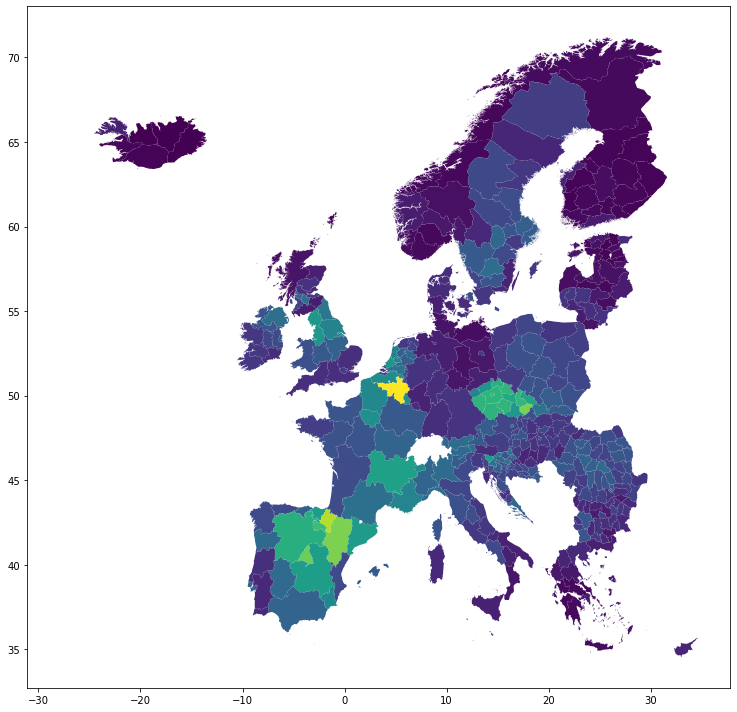

In [4]:
fig, ax = plt.subplots(figsize=(12,10))
gdf.plot(column="Total_Inf", ax=ax)
plt.tight_layout()
plt.show()

## Spatial Weights and Spatial Lag

Example notebook on spatial weights <br>
http://darribas.org/gds15/content/labs/lab_05.html

In [5]:
from libpysal.weights import Queen, Rook, KNN
#Spatial Weights, select one
#w = weights.Queen.from_dataframe(gdf, idVariable="REG_NAME") # Queen Contiguity Matrix
#w = weights.Rook.from_dataframe(gdf, idVariable="REG_NAME")  # Rook contiguity Matrix
w = weights.distance.KNN.from_dataframe(gdf, ids="REG_NAME", k=6) # K-Nearest Neighbors

w.transform = "R"

C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [6]:
#Spatial lag
gdf["w_infections"] = weights.lag_spatial(w, gdf["Total_Inf"])
gdf.head()

,REG_NAME,Total_Inf,geometry,w_infections
0,Kralovehradecky Kraj,7513.14378,"POLYGON ((16.10732 50.66207, 16.11313 50.65936...",6478.451495
1,Salzburg,3210.07311,"POLYGON ((13.30382 48.00782, 13.30366 48.00400...",3264.946178
2,Illes Balears,3187.54103,"MULTIPOLYGON (((3.17671 39.95323, 3.17925 39.9...",5480.352492
3,Burgenland,2358.28963,"POLYGON ((17.16080 48.00666, 17.13656 47.99510...",2927.325468
4,Tirol,4071.39213,"MULTIPOLYGON (((10.45444 47.55580, 10.47320 47...",3088.255467


## Global Spatial Autocorrelation

In [7]:
y = gdf["Total_Inf"]
moran = Moran(y, w)
moran.I

0.6711515428066936

Test for global spatial autocorrelation against the null hypothesis

Text(0.5, 0, "Moran's I")

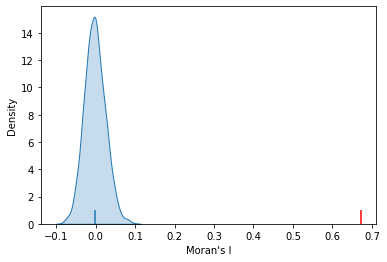

In [10]:
import seaborn as sbn
sbn.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

If the Moran's I value lies outside the curve, the value is proven to be statistically significant

In [11]:
# Get the P-value
moran.p_sim

0.001

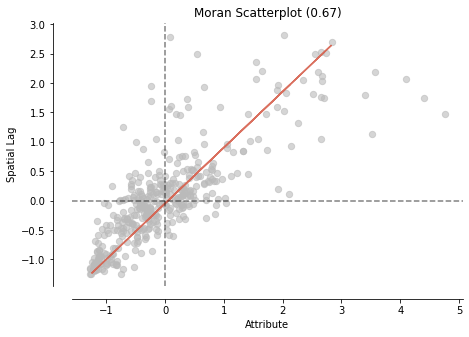

In [12]:
# Create a morans scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
#plt.savefig("../Output/scatter-moran.png")
plt.show()

## Local Spatial Autocorrelation

In [13]:
# calculate Moran Local 

m_local = esda.moran.Moran_Local(y, w)
lisa = m_local.Is

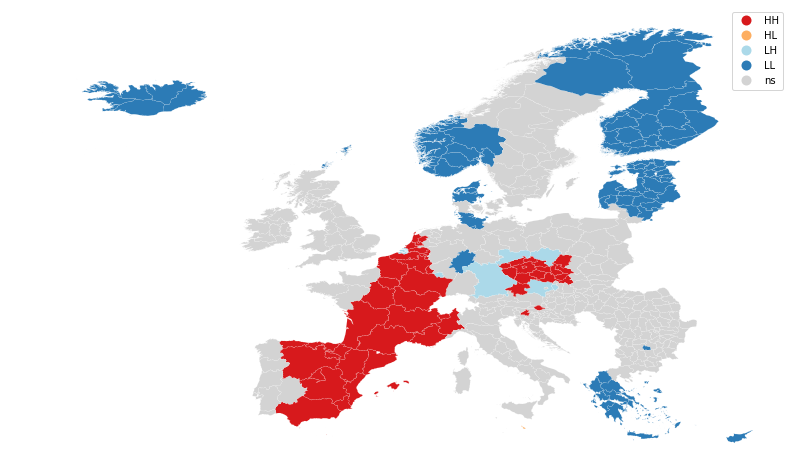

In [14]:
# Plot Spatial Autocorrelation results 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(m_local, gdf, p=0.05, figsize = (14,12),ax=ax)
plt.show()

In [15]:
# Specify feature types 
sig = 1 * (m_local.p_sim < 0.05)
hotspot = 1 * (sig * m_local.q==1)
coldspot = 3 * (sig * m_local.q==3)
doughnut = 2 * (sig * m_local.q==2)
diamond = 4 * (sig * m_local.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [16]:
spot_labels = ['0 ns', '1 Hotspot', '2 Doughnut', '3 Coldspot', '4 Diamond']
labels = [spot_labels[i] for i in spots]

HH: Hotspots, a cluster where everything tends to be above-mean. <br>
LL: Coldspots, a cluster where everything tends to be below-mean. <br>
LH: Donuts,  an  outlier  where  there  is  a  low  value  surrounded  by  high values. <br>
HL: Diamonds(in  the  Rough),  an  outlier  where  there  is  a  high  value surrounded by low values. <br>

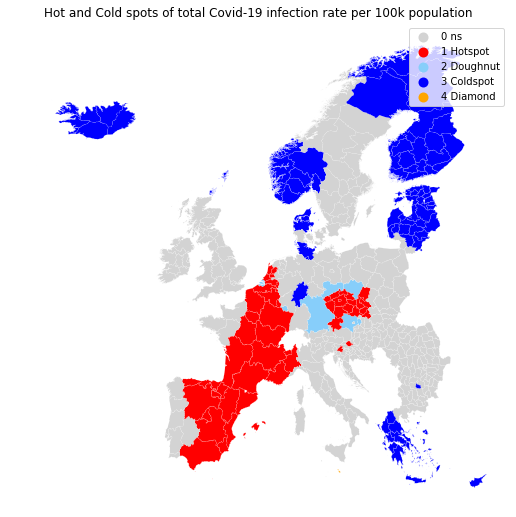

In [18]:
from matplotlib import colors
hc_df = gdf.assign(cl=labels)
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightskyblue', 'blue', 'orange'])
f, ax = plt.subplots(1, figsize=(9, 9))
hc_df.plot(column='cl', categorical=True, \
        k=6, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot and Cold spots of total Covid-19 infection rate per 100k population")

#plt.savefig('../Output/EU_Hot_&_Cold_Spots.png', dpi=300)
plt.show()